<a href="https://colab.research.google.com/github/RileyWClarke/MLTSA_COVID19/blob/master/covid19_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/Shared\ drives/

/content/gdrive/Shared drives


In [4]:
cd Covid19_project/

/content/gdrive/Shared drives/Covid19_project


In [5]:
cd data_sets/

/content/gdrive/Shared drives/Covid19_project/data_sets


In [6]:
ls

ALLvSK.png               death_corr_t0_at_50.png  test_corr_t0_at_100.png
CAvSK.png                death_corr_t0_at_5.png   test_corr_t0_at_10.png
dataslide_sk_plot.png    FLvSK.png                test_corr_t0_at_1.png
data_us_plot.png         global1/                 test_corr_t0_at_500.png
DCvSK.png                NEvSK.png                usa_1/
death_corr_t0_at_10.png  NYvSK.png                weather_c19/
death_corr_t0_at_30.png  skcv19_data/


In [0]:
us_state = pd.read_csv('usa_1/us_states_covid19_daily.csv') 
skorea = pd.read_csv('skcv19_data/Time.csv') 
uscities = pd.read_csv('usa_1/uscities.csv') 
w_ca = pd.read_csv('weather_c19/avg_temp_humid_ca.csv')
w_ny = pd.read_csv('weather_c19/avg_temp_humid_ny.csv')
w_dc = pd.read_csv('weather_c19/avg_temp_humid_dc.csv')
w_ne = pd.read_csv('weather_c19/avg_temp_humid_ne.csv')
w_fl = pd.read_csv('weather_c19/avg_temp_humid_fl.csv')
w_sk = pd.read_csv('weather_c19/avg_temp_humid_sk.csv')

In [75]:
us_state.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200430,AK,355.0,18764.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,252.0,78605f774dcba587c8b24512354a3830ef3b5e4f,2020-04-30T20:00:00Z,9.0,NaN,19119.0,19119.0,19119.0,2,0.0,0.0,0.0,0.0,0.0
1,20200430,AL,7019.0,80177.0,NaN,NaN,978.0,NaN,335.0,NaN,195.0,NaN,47546b95299bd673c18e27d5284d7ba75b362464,2020-04-30T20:00:00Z,269.0,978.0,87196.0,87196.0,87196.0,1,24.0,33.0,6570.0,177.0,6747.0
2,20200430,AR,3255.0,45124.0,NaN,95.0,402.0,NaN,NaN,23.0,85.0,1305.0,8f880ed4454e1fc3bbeff4b0655314f8878cbe22,2020-04-30T20:00:00Z,61.0,402.0,48379.0,48379.0,48379.0,5,2.0,13.0,2867.0,63.0,2930.0
3,20200430,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14c16072106c6d59a534dfcbd590ca14f42e4a7f,2020-04-30T20:00:00Z,0.0,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200430,AZ,7648.0,64138.0,NaN,755.0,1169.0,311.0,NaN,194.0,NaN,1499.0,eb3be7d08e6c0e46e5aa79eb92b2da29f2e6dc13,2020-04-30T20:00:00Z,320.0,1169.0,71786.0,71786.0,71786.0,4,16.0,38.0,2527.0,446.0,2973.0


In [76]:
us_state['state'].unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [77]:
skorea.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [78]:
skorea_d10 = skorea.loc[skorea['deceased'] >= 10]
skorea_d10

,date,time,test,negative,confirmed,released,deceased
36,2020-02-25,16,40304,25447,977,24,12
37,2020-02-26,16,53553,31576,1261,24,12
38,2020-02-27,16,66652,39318,1766,26,13
39,2020-02-28,16,81167,48593,2337,27,13
40,2020-02-29,16,94055,55723,3150,28,17
...,...,...,...,...,...,...,...
97,2020-04-26,0,598285,578558,10728,8717,242
98,2020-04-27,0,601660,582027,10738,8764,243
99,2020-04-28,0,608514,588559,10752,8854,244
100,2020-04-29,0,614197,595129,10761,8922,246


In [79]:
d10 = np.arange(0,len(skorea_d10),1)
skorea_d10['d10'] = d10
skorea_d10

,date,time,test,negative,confirmed,released,deceased,d10
36,2020-02-25,16,40304,25447,977,24,12,0
37,2020-02-26,16,53553,31576,1261,24,12,1
38,2020-02-27,16,66652,39318,1766,26,13,2
39,2020-02-28,16,81167,48593,2337,27,13,3
40,2020-02-29,16,94055,55723,3150,28,17,4
...,...,...,...,...,...,...,...,...
97,2020-04-26,0,598285,578558,10728,8717,242,61
98,2020-04-27,0,601660,582027,10738,8764,243,62
99,2020-04-28,0,608514,588559,10752,8854,244,63
100,2020-04-29,0,614197,595129,10761,8922,246,64


Text(0, 0.5, 'Deaths')

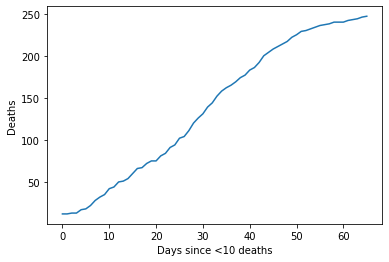

In [80]:
plt.plot(skorea_d10['d10'], skorea_d10['deceased'])
plt.xlabel('Days since <10 deaths')
plt.ylabel('Deaths')

In [0]:
states = ['CA', 'NY', 'DC']

us_CA = us_state.loc[(us_state['state'] == 'CA') & (us_state['death'] >= 10)][['date', 'state', 'death']]
us_NY = us_state.loc[(us_state['state'] == 'NY') & (us_state['death'] >= 10)][['date', 'state', 'death']]
us_DC = us_state.loc[(us_state['state'] == 'DC') & (us_state['death'] >= 10)][['date', 'state', 'death']]
us_NE = us_state.loc[(us_state['state'] == 'NE') & (us_state['death'] >= 10)][['date', 'state', 'death']]
us_FL = us_state.loc[(us_state['state'] == 'FL') & (us_state['death'] >= 10)][['date', 'state', 'death']]


us_CA['d10'] = np.arange(0,len(us_CA),1)
us_NY['d10'] = np.arange(0,len(us_NY),1)
us_DC['d10'] = np.arange(0,len(us_DC),1)
us_NE['d10'] = np.arange(0,len(us_NE),1)
us_FL['d10'] = np.arange(0,len(us_FL),1)

In [82]:
us_DC

,date,state,death,d10
8,20200430,DC,224.0,0
64,20200429,DC,205.0,1
120,20200428,DC,190.0,2
176,20200427,DC,185.0,3
232,20200426,DC,178.0,4
288,20200425,DC,165.0,5
344,20200424,DC,153.0,6
400,20200423,DC,139.0,7
456,20200422,DC,127.0,8
512,20200421,DC,112.0,9


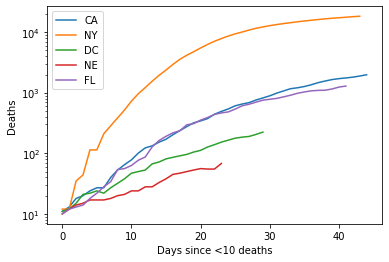

In [17]:
plt.plot(us_CA['d10'], us_CA['death'][::-1], label='CA')
plt.plot(us_NY['d10'], us_NY['death'][::-1], label='NY')
plt.plot(us_DC['d10'], us_DC['death'][::-1], label='DC')
plt.plot(us_NE['d10'], us_NE['death'][::-1], label='NE')
plt.plot(us_FL['d10'], us_FL['death'][::-1], label='FL')
plt.yscale('log')
plt.xlabel('Days since <10 deaths')
plt.ylabel('Deaths')
plt.legend();

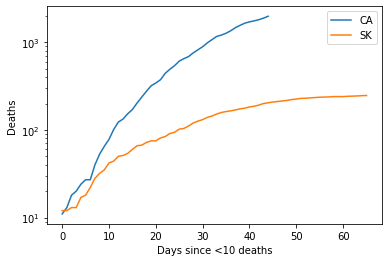

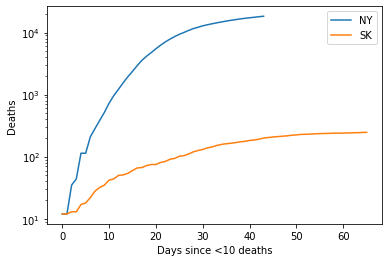

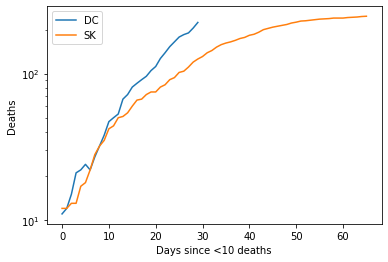

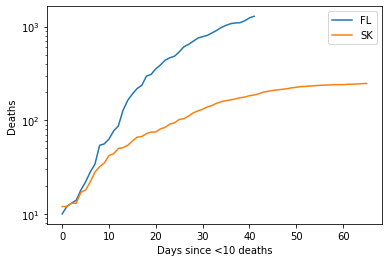

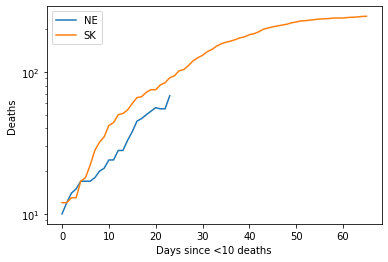

In [24]:
plt.plot(us_CA['d10'], us_CA['death'][::-1], label='CA')
plt.plot(skorea_d10['d10'], skorea_d10['deceased'], label='SK')
plt.yscale('log')
plt.xlabel('Days since <10 deaths')
plt.ylabel('Deaths')
plt.legend()
plt.savefig('CAvSK.png', bbox_inches='tight')
plt.show()

plt.plot(us_NY['d10'], us_NY['death'][::-1], label='NY')
plt.plot(skorea_d10['d10'], skorea_d10['deceased'], label='SK')
plt.yscale('log')
plt.xlabel('Days since <10 deaths')
plt.ylabel('Deaths')
plt.legend()
plt.savefig('NYvSK.png', bbox_inches='tight')
plt.show()

plt.plot(us_DC['d10'], us_DC['death'][::-1], label='DC')
plt.plot(skorea_d10['d10'], skorea_d10['deceased'], label='SK')
plt.yscale('log')
plt.xlabel('Days since <10 deaths')
plt.ylabel('Deaths')
plt.legend()
plt.savefig('DCvSK.png', bbox_inches='tight')
plt.show()

plt.plot(us_FL['d10'], us_FL['death'][::-1], label='FL')
plt.plot(skorea_d10['d10'], skorea_d10['deceased'], label='SK')
plt.yscale('log')
plt.xlabel('Days since <10 deaths')
plt.ylabel('Deaths')
plt.legend()
plt.savefig('FLvSK.png', bbox_inches='tight')
plt.show()

plt.plot(us_NE['d10'], us_NE['death'][::-1], label='NE')
plt.plot(skorea_d10['d10'], skorea_d10['deceased'], label='SK')
plt.yscale('log')
plt.xlabel('Days since <10 deaths')
plt.ylabel('Deaths')
plt.legend()
plt.savefig('NEvSK.png', bbox_inches='tight')
plt.show()

In [28]:
from scipy.spatial.distance import minkowski
print(
minkowski(us_CA['death'][::-1],skorea_d10['deceased'][:len(us_CA['death'])], p=2),
minkowski(us_NY['death'][::-1],skorea_d10['deceased'][:len(us_NY['death'])], p=2),
minkowski(us_DC['death'][::-1],skorea_d10['deceased'][:len(us_DC['death'])], p=2),
minkowski(us_NE['death'][::-1],skorea_d10['deceased'][:len(us_NE['death'])], p=2),
minkowski(us_FL['death'][::-1],skorea_d10['deceased'][:len(us_FL['death'])], p=2)
)

5360.885467905466 66059.58364234518 233.42022191746798 85.74963556773871 3384.8438664139294


In [29]:
print(
minkowski(us_CA['death'][::-1],skorea_d10['deceased'][:len(us_CA['death'])], p=1),
minkowski(us_NY['death'][::-1],skorea_d10['deceased'][:len(us_NY['death'])], p=1),
minkowski(us_DC['death'][::-1],skorea_d10['deceased'][:len(us_DC['death'])], p=1),
minkowski(us_NE['death'][::-1],skorea_d10['deceased'][:len(us_NE['death'])], p=1),
minkowski(us_FL['death'][::-1],skorea_d10['deceased'][:len(us_FL['death'])], p=1)
)

25273.0 332441.0 883.0 355.0 16014.0


In [30]:
from scipy.stats import pearsonr
print(
pearsonr(us_CA['death'][::-1],skorea_d10['deceased'][:len(us_CA['death'])]),
pearsonr(us_NY['death'][::-1],skorea_d10['deceased'][:len(us_NY['death'])]),
pearsonr(us_DC['death'][::-1],skorea_d10['deceased'][:len(us_DC['death'])]),
pearsonr(us_NE['death'][::-1],skorea_d10['deceased'][:len(us_NE['death'])]),
pearsonr(us_FL['death'][::-1],skorea_d10['deceased'][:len(us_FL['death'])])
)

(0.978516626249864, 4.010444404473293e-31) (0.9898639311547096, 3.0938815771714726e-37) (0.9867592338948894, 1.1500049219179493e-23) (0.9731593191616311, 1.5853207394042909e-15) (0.9907238916021059, 2.6889697209879946e-36)


|     |Minkowski (p=2)|Minkowski (p=1)|Pearson R|
|-----|---------------|---------------|---------|
|  CA |5360.88        |25273.0        |0.978|  
|  NY |66059.58       |332441.0      |0.989|  
|  DC |233.42         |883.0         |0.986|  
|  NE |85.749         |355.0         |0.973|  
|  FL |3384.84        |16014.0       |0.991|  

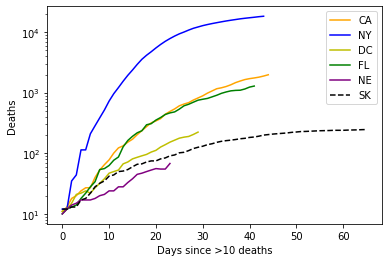

In [46]:
plt.plot(us_CA['d10'], us_CA['death'][::-1], c='orange', label='CA')
plt.plot(us_NY['d10'], us_NY['death'][::-1], c='b', label='NY')
plt.plot(us_DC['d10'], us_DC['death'][::-1], c='y', label='DC')
plt.plot(us_FL['d10'], us_FL['death'][::-1], c='g', label='FL')
plt.plot(us_NE['d10'], us_NE['death'][::-1], c='purple', label='NE')
plt.plot(skorea_d10['d10'], skorea_d10['deceased'], c='k', ls='--', label='SK')
plt.yscale('log')
plt.xlabel('Days since >10 deaths')
plt.ylabel('Deaths')
plt.legend()
plt.savefig('ALLvSK.png', bbox_inches='tight')
plt.show()

In [0]:
w_sk['date_time'] = pd.to_datetime(w_sk['date_time'])

In [0]:
w_sk = w_sk.rename(columns={'date_time':'date'})

In [100]:
w_sk.loc[w_sk['date'] >= '2020-02-25']

,date,avg_tempC,avg_humidity
86,2020-02-25,6.5,83.5
87,2020-02-26,11.5,75.0
88,2020-02-27,10.5,68.0
89,2020-02-28,6.0,77.5
90,2020-02-29,14.0,70.0
...,...,...,...
177,2020-04-26,18.0,44.0
178,2020-04-27,17.5,43.5
179,2020-04-28,19.5,42.5
180,2020-04-29,24.0,45.5


In [0]:
skorea_d10['date'] = pd.to_datetime(skorea_d10['date'])

In [102]:
skorea_w = skorea_d10.merge(w_sk.loc[w_sk['date'] >= '2020-02-25'])
skorea_w

,date,time,test,negative,confirmed,released,deceased,d10,avg_tempC,avg_humidity
0,2020-02-25,16,40304,25447,977,24,12,0,6.5,83.5
1,2020-02-26,16,53553,31576,1261,24,12,1,11.5,75.0
2,2020-02-27,16,66652,39318,1766,26,13,2,10.5,68.0
3,2020-02-28,16,81167,48593,2337,27,13,3,6.0,77.5
4,2020-02-29,16,94055,55723,3150,28,17,4,14.0,70.0
...,...,...,...,...,...,...,...,...,...,...
91,2020-04-28,0,608514,588559,10752,8854,244,63,19.5,42.5
92,2020-04-29,0,614197,595129,10761,8922,246,64,24.0,45.5
93,2020-04-29,0,614197,595129,10761,8922,246,64,24.0,45.5
94,2020-04-30,0,619881,600482,10765,9059,247,65,22.5,52.0


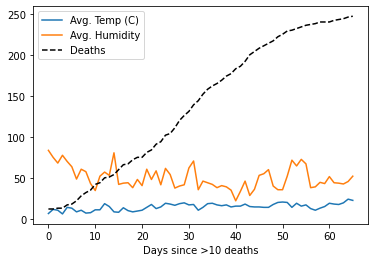

In [107]:
plt.plot(skorea_w['d10'], skorea_w['avg_tempC'], label='Avg. Temp (C)')
plt.plot(skorea_w['d10'], skorea_w['avg_humidity'], label='Avg. Humidity')
plt.plot(skorea_w['d10'], skorea_w['deceased'], c='k', ls='--', label='Deaths')
plt.xlabel('Days since >10 deaths')
plt.legend();

In [12]:
uscities.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,South Creek,South Creek,WA,Washington,53053,Pierce,53053,Pierce,46.9994,-122.3921,2500.0,125.0,polygon,False,True,America/Los_Angeles,3,98580 98387 98338,1840042075
1,Roslyn,Roslyn,WA,Washington,53037,Kittitas,53037,Kittitas,47.2507,-121.0989,947.0,84.0,polygon,False,True,America/Los_Angeles,3,98941 98068 98925,1840019842
2,Sprague,Sprague,WA,Washington,53043,Lincoln,53043,Lincoln,47.3048,-117.9713,441.0,163.0,polygon,False,True,America/Los_Angeles,3,99032,1840021107
3,Gig Harbor,Gig Harbor,WA,Washington,53053,Pierce,53053,Pierce,47.3352,-122.5968,9507.0,622.0,polygon,False,True,America/Los_Angeles,3,98332 98335,1840019855
4,Lake Cassidy,Lake Cassidy,WA,Washington,53061,Snohomish,53061,Snohomish,48.0639,-122.0920,3591.0,131.0,polygon,False,True,America/Los_Angeles,3,98223 98258 98270,1840041959


In [38]:
uscities.loc[(uscities['state_id'] == 'NE') & (uscities['population'] > 100000)]

,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
8204,Omaha,Omaha,NE,Nebraska,31055,Douglas,31055,Douglas,41.2628,-96.0498,827786.0,1304.0,polygon,False,True,America/Chicago,2,68112 68117 68118 68107 68104 68105 68108 6817...,1840009315
8274,Lincoln,Lincoln,NE,Nebraska,31109,Lancaster,31109,Lancaster,40.8088,-96.6796,285118.0,1159.0,polygon,False,True,America/Chicago,2,68528 68524 68526 68520 68521 68522 68516 6851...,1840009357


In [0]:
ca_mean_den = uscities['density'].loc[(uscities['state_id'] == 'CA') & (uscities['population'] > 100000)].mean()
ny_mean_den = uscities['density'].loc[(uscities['state_id'] == 'NY') & (uscities['population'] > 100000)].mean()
dc_mean_den = uscities['density'].loc[(uscities['state_id'] == 'DC') & (uscities['population'] > 100000)].mean()
ne_mean_den = uscities['density'].loc[(uscities['state_id'] == 'NE') & (uscities['population'] > 100000)].mean()
fl_mean_den = uscities['density'].loc[(uscities['state_id'] == 'FL') & (uscities['population'] > 100000)].mean()

In [27]:
daegu_den = 2818
np.array([ca_mean_den, ny_mean_den, dc_mean_den, ne_mean_den, fl_mean_den]) / daegu_den

array([0.76369443, 2.44552874, 1.55500355, 0.43701207, 0.44993494])


                                     
|     |Minkowski (p=2)|Minkowski (p=1)|Pearson R|$\frac{\bar{\rho}_{state}}{\rho_{SK}}$
|-----|---------------|---------------|---------|--------|
|  CA |5360.88        |25273.0        |0.978    |0.76    |
|  NY |66059.58       |332441.0       |0.989    |2.45    |
|  DC |233.42         |883.0          |0.986    |1.55    |
|  NE |85.749         |355.0          |0.973    |0.44    |
|  FL |3384.84        |16014.0        |0.991    |0.45    |

(25.0, 50.0)

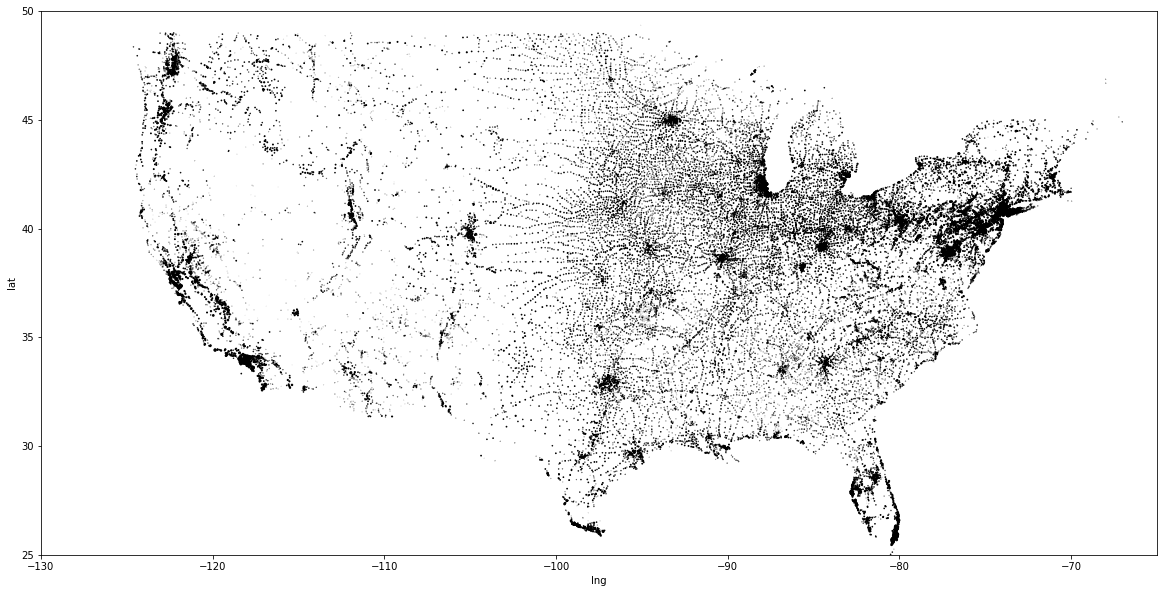

In [72]:
plt.figure(figsize=(20,10))
uscities.plot.scatter('lng','lat', s=uscities['density']*0.001, c='k', ax=plt.gca())
plt.xlim(-130,-65)
plt.ylim(25,50)